In [276]:
!pip install darts

In [277]:
!pip install tensorflow

In [278]:
!pip install pendulum

In [279]:
pip install prophet

In [ ]:
from pendulum import DateTime
from pendulum import duration
import pandas as pd
import numpy as np
from random import randint
from sklearn.model_selection import train_test_split

In [ ]:
def generate_synthetic_data(duration_cycle, start_day, year, start_month_index=1, number_of_cycle=5, period_duration=30, cycle_interval=[5, 6], period_interval=[26, 30]):
    """
    function that generate the synthetic data

        Args:
            duration_cycle (int): duration of the cycle in days
            start_day (int): day of the first cycle
            year (int): year of the first cycle
            start_month_index (int): month of the first cycle
            number_of_cycle (int): number of cycles
            period_duration (int): duration of the period between cycles in days
            cycle_interval (list): interval of the duration of the cycle in days
            period_interval (list): interval of the duration of the period between cycles in days

        Return:
            df (pd.DataFrame): dataframe with the synthetic data
        """
    data_frame = pd.DataFrame(columns=['M', 'Day', 'Year', 'Duration'])

    start_time = DateTime(year, start_month_index, start_day, 1, 0, 0)
    end_time = start_time+duration(days=duration_cycle)

    for _ in range(0, number_of_cycle+1):

            data_frame = pd.concat([data_frame, pd.DataFrame(np.array([[start_time.month, start_time.day, start_time.year, 'Starts']]),
                                                             columns=['M', 'Day', 'Year', 'Duration'])],  ignore_index=True, axis=0)

            data_frame = pd.concat([data_frame, pd.DataFrame(np.array([[end_time.month, end_time.day, end_time.year, 'Ends']]),
                                                             columns=['M', 'Day', 'Year', 'Duration'])],  ignore_index=True, axis=0)

            #TODO(Cibely): Make the durantion_cycle and period_duration be random values
            duration_cycle = randint(cycle_interval[0], cycle_interval[1])
            period_duration = randint(period_interval[0], period_interval[1])

            start_time = start_time+duration(days=period_duration)
            end_time = start_time+duration(days=duration_cycle)

    return data_frame


def calculate_period_length(dates, dates_numbers):
    """
    function that calculate the length of the period

    Args:
        dates (list): list of dates
        dates_numbers (int): number of dates

    Returns:
        period_length (list): list of length of the period in days
    """
    period_length = []
    for index in range(0,dates_numbers,2):
        period_length.append((dates[index+1] - dates[index]).days)

    return period_length


def calculate_cycle_length(dates, dates_numbers):
    """
    function that calculate the length of the cycle

    Args:
        dates (list): list of dates
        dates_numbers (int): number of dates

    Returns:
        cycle_length (list): list of length of the cycle in days
    """
    cycle_length = []
    for index in range(0,dates_numbers-2,2):
        cycle_length.append((dates[index+2] - dates[index]).days)

    return cycle_length


def calculate_datatime(dataset):
    """
    function that calculate the datetime of the dates

    Args:
        dataset (pd.DataFrame): dataframe with the data

    Returns:
        formatted_dataset (list): list with the features
    """

    dates_format=pd.to_datetime(dict(year=dataset.Year, month=dataset.M, day=dataset.Day))
    period_length=calculate_period_length(dates_format, len(dataset))
    cycle=calculate_cycle_length(dates_format, len(dataset))

    formatted_dataset=[]
    index=0
    for date_index in range(0,len(dates_format)-2,2):
        formatted_dataset.append([dates_format[date_index].date(), cycle[index], period_length[index]])
        index+=1

    return formatted_dataset


def prepared_the_features(periods):
    """
    function that prepare the features for the prediction


    Args:
        periods (list): list of the periods

    Returns:
        features (np.array): array with the features
        labels (np.array): array with the labels
    """

    features = []
    labels = []
    for period in periods[:-3]:
        p_index = periods.index(period)
        features.append([])
        features[-1].append([period[-2], period[-1]])
        features[-1].append([periods[p_index + 1][-2], periods[p_index + 1][-1]])
        features[-1].append([periods[p_index + 2][-2], periods[p_index + 2][-1]])
        labels.append([periods[p_index + 3][-2], periods[p_index + 3][-1]])
    #TODO(Cibely): verify that len(features) == len(labels) must be true

    return features, labels


def generate_final_features(dataset):
    """
    function that generate the final dataset

    Args:
        dataset (pd.DataFrame): dataframe with the data

    Returns:
        final_dataset (list): list with the final dataset
    """

    dataset_with_datatime = calculate_datatime(dataset)

    return prepared_the_features(dataset_with_datatime)

def split_dataset(features, labels, test_size=0.2, random_state=0, reshape=True):
    """
    function that split the dataset

    Args:
        features (np.array): array with the features
        labels (np.array): array with the labels
        test_size (float): percentage of the test size
        random_state (int): random state

    Returns:
        train_features (np.array): array with the train features
        test_features (np.array): array with the test features
        train_labels (np.array): array with the train labels
        test_labels (np.array): array with the test labels
    """


    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=test_size, random_state=random_state)
    train_features = np.array(train_features)
    test_features = np.array(test_features)
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)
    if reshape:
        train_features = train_features.reshape(train_features.shape[0], train_features.shape[1]*train_features.shape[2])
        test_features = test_features.reshape(test_features.shape[0], test_features.shape[1]*test_features.shape[2])
        train_labels = train_labels.reshape(train_labels.shape[0], train_labels.shape[1]*1)
        test_labels = test_labels.reshape(test_labels.shape[0], test_labels.shape[1]*1)

    return train_features, test_features, train_labels, test_labels

def create_dataset(dataset, look_back=1):
    """
        This function is used to create dataset for LSTM model
        Args:
            dataset: The dataset
            look_back: The number of previous time steps to use as input variables to predict the next time period
        Returns:
            dataX: The input data
            dataY: The output data
    """
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


def convet2dataframe(data, columns):
    """
    function that convert the data to dataframe

    Args:
        data (np.array): array with the data
        columns (list): list with the columns

    Returns:

    """
    data = data.reshape(1,-1,2)
    data_frame = pd.DataFrame(data[0], columns=columns)
    data_frame['time'] = data_frame.index
    return data_frame

In [ ]:
def evaluate_predictions(test_y, predictions):
    """ Evaluate on the test set. """
    assert len(test_y) == len(predictions)

    right_cycle = 0
    right_menstr = 0

    for idx, y in enumerate(test_y):
        if y[0] == predictions[idx][0]:
            right_cycle += 1
        if y[1] == predictions[idx][1]:
            right_menstr += 1

    return right_cycle / len(test_y), right_menstr / len(test_y)
def print_predictions(last_known_period, predictions):

    # add the first predicted period
    next_periods = [[
        last_known_period + timedelta(days = predictions[0][0]),
        last_known_period + timedelta(days = predictions[0][0] + predictions[0][1]),
        predictions[0][1]
        ]]

    # add the next ones
    for period in predictions[1:]:
        last_period = next_periods[-1]
        next_periods.append([
            last_period[0] + timedelta(days = period[0]),
            last_period[0] + timedelta(days = period[0] + period[1]),
            period[1]
            ])

    for num, period in enumerate(next_periods):
        print(str(num) + ". From " + period[0].strftime('%d.%m.%Y') + \
              " to " + period[1].strftime('%d.%m.%Y') + ", length: " + str(period[2]))

    return next_periods

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import AutoARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np
import pandas as pd
total_regular_cycle_data = pd.read_csv('regular_cycle_data.csv')

In [ ]:
total_regular_cycle_data.dtypes

M            int64
Day          int64
Year         int64
Duration    object
dtype: object

In [ ]:
total_regular_cycle_data = pd.read_csv('total_regular_cycle_data.csv')
features_total_regular_cycle_data, labels_total_regular_cycle_data = generate_final_features(total_regular_cycle_data)
input_train_total_regular_cycle, input_test_total_regular_cycle, output_train_total_regular_cycle, output_test_total_regular_cycle = split_dataset(features_total_regular_cycle_data, labels_total_regular_cycle_data, reshape=False)


In [ ]:
input_train_total_regular_cycle_df = convet2dataframe(input_train_total_regular_cycle, ['period', 'cycle'])
output_train_total_regular_cycle = convet2dataframe(output_train_total_regular_cycle, ['period', 'cycle'])
input_test_total_regular_cycle_df = convet2dataframe(input_test_total_regular_cycle, ['period', 'cycle'])
series_test = TimeSeries.from_dataframe(input_test_total_regular_cycle_df, 'time', ['period'])
output_train_series = TimeSeries.from_dataframe(output_train_total_regular_cycle, 'time', ['period'])
series = TimeSeries.from_dataframe(input_train_total_regular_cycle_df, time_col='time', value_cols=['period'])


In [ ]:
input_train_total_regular_cycle_df.to_csv('modified_dataset.csv', index=False)

In [ ]:
input_train_total_regular_cycle_df.dtypes

period    int64
cycle     int64
time      int64
dtype: object

In [280]:
series_cycle = TimeSeries.from_dataframe(input_train_total_regular_cycle_df, time_col='time', value_cols=['cycle'])
series_cycle_test = TimeSeries.from_dataframe(input_test_total_regular_cycle_df, time_col='time', value_cols=['cycle'])


In [284]:
pip install prophet

In [ ]:
model = AutoARIMA()
model.fit(series)

AutoARIMA(add_encoders=None)

In [ ]:
prediction_ = model.predict(len(series_test))

In [ ]:
prediction=prediction_.values()

In [ ]:
prediction

array([[29.0625],
       [29.0625],
       [29.0625],
       [29.0625],
       [29.0625],
       [29.0625],
       [29.0625],
       [29.0625],
       [29.0625],
       [29.0625],
       [29.0625],
       [29.0625],
       [29.0625],
       [29.0625],
       [29.0625]])

In [ ]:
model_cycle = AutoARIMA()
model_cycle.fit(series_cycle)

AutoARIMA(add_encoders=None)

In [ ]:
testScore = np.sqrt(mean_squared_error(series_test.values(), prediction_.values()))
print('Test Score: %.2f MSE' % (testScore))
# calculate mean absolute error
testScore = mean_absolute_error(series_test.values(), prediction_.values())
print('Test Score: %.2f MAE' % (testScore))
# RMSE
print('Test Score: %.2f RMSE' % np.sqrt(testScore))
# calculate r2 score
testScore = r2_score(series_test.values(), prediction_.values())
print('Test Score: %.2f R2' % (testScore))


Test Score: 0.84 MSE
Test Score: 0.74 MAE
Test Score: 0.86 RMSE
Test Score: -0.03 R2


In [ ]:
import numpy as np #Para trabalhar com arrays
import pandas as pd
import matplotlib.pyplot as plt #Para plotar os gráficos
from sklearn.linear_model import LinearRegression #Para importar o modelo de regressão linear
from sklearn.model_selection import train_test_split #Para dividir o dataset em treino e teste
from sklearn.metrics import mean_squared_error
from math import sqrt


df =  pd.read_csv('irregular_cycle_data.csv', sep=',', header=0)

periods_data =calculate_datatime(df)
features, labels =generate_final_features(df)



x_train, x_test, y_train, y_test  = train_test_split(features, labels, test_size=0.2, random_state=10)

train_y=np.array(y_train)
train_x= np.array(x_train)
test_x= np.array(x_test)
test_y= np.array(y_test)
train_x = train_x.reshape((train_x.shape[0],train_x.shape[1]*train_x.shape[2]))
train_y = train_y.reshape((train_y.shape[0],train_y.shape[1]*1))
test_x = test_x.reshape((test_x.shape[0],test_x.shape[1]*test_x.shape[2]))
test_y = test_y.reshape((test_y.shape[0],test_y.shape[1]*1))

model_LR= LinearRegression()
model_LR.fit(train_x, train_y)

LinearRegression()

In [ ]:
y_pred = model_LR.predict(test_x)
output_pred = [[int(round(i[0])), int(round(i[1]))] for i in y_pred] # round the values

cycle_length=[]
periods=[]
for i in range(len(output_pred)):
  cycle_length.append(output_pred[i][0] )
  periods.append(output_pred[i][1] )


In [ ]:
predicted = model_LR.predict([test_x[-1]])
cycles_numbers = np.arange(1, len(cycle_length)+1)

In [ ]:
cycles_numbers

array([1, 2, 3, 4, 5])

In [ ]:
predicted

array([[47.04146173,  6.59074435]])

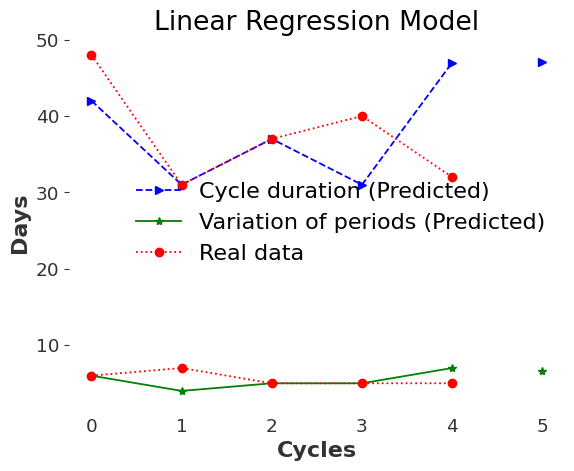

In [ ]:
plt.plot(cycle_length, '-->', color='blue')
plt.plot(periods, '-*', color='green')
plt.plot(test_y, ':o', color='red')
plt.plot(cycles_numbers[-1], predicao_um_passo_a_frente[0][0], '-->', color='blue')
plt.plot(cycles_numbers[-1], predicao_um_passo_a_frente[0][1], '-*', color='green')
plt.legend(['Cycle duration (Predicted)', 'Variation of periods (Predicted)', 'Real data'])
plt.grid()
plt.xlabel('Cycles')
plt.ylabel('Days')
plt.title('Linear Regression Model')
fig = plt.gcf()
fig.savefig('linear.png', dpi=300, bbox_inches='tight')
plt.show()

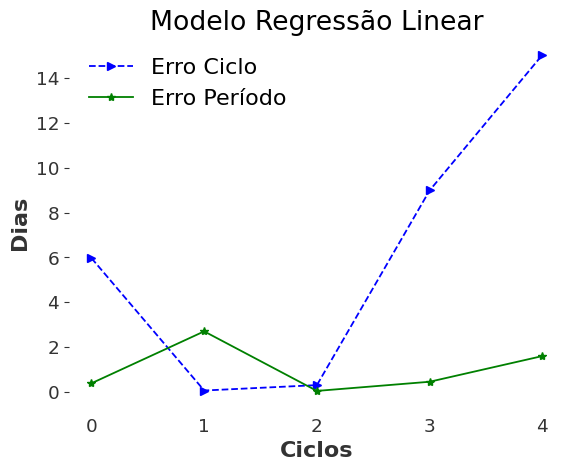

In [ ]:
error = abs(test_y-y_pred)
plt.plot(error[:,0], '-->', color='blue')
plt.plot(error[:,1], '-*', color='green')
plt.legend(['Erro Ciclo', 'Erro Período'])
plt.grid()
plt.xlabel('Ciclos')
plt.ylabel('Dias')
plt.title('Modelo Regressão Linear')
fig = plt.gcf()
fig.savefig('linear_error.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
rms = sqrt(mean_squared_error(test_y, y_pred))
print('RMSE: ', rms)

    # calcular o MAE (Mean Absolute Error)
mae = np.mean(np.abs((test_y - y_pred)))
print('MAE: ', mae)

RMSE:  1.3667218077151158
MAE:  1.0476090951456167


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
import warnings
warnings.filterwarnings("ignore")

In [ ]:
total_regular_cycle_data = pd.read_csv('regular_cycle_data.csv')
features_total_regular_cycle_data, labels_total_regular_cycle_data = generate_final_features(total_regular_cycle_data)
input_train_total_regular_cycle, input_test_total_regular_cycle, output_train_total_regular_cycle, output_test_total_regular_cycle = split_dataset(features_total_regular_cycle_data, labels_total_regular_cycle_data, reshape=False)


In [ ]:
n_features = input_train_total_regular_cycle.shape[2]
model = Sequential()
model.add(LSTM(64, input_shape=(3, n_features),  activation='tanh'))
model.add(Dropout(0.05))
model.add(Dense(n_features, activation='relu'))
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 64)                17152     
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 2)                 130       
                                                                 
Total params: 17282 (67.51 KB)
Trainable params: 17282 (67.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
opt=tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt, run_eagerly=True)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(input_train_total_regular_cycle, output_train_total_regular_cycle, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/100
1/1 [==============================] - 0s 456ms/step - loss: 498.2730 - val_loss: 462.9476
Epoch 2/100
1/1 [==============================] - 0s 487ms/step - loss: 476.1724 - val_loss: 443.4565
Epoch 3/100
1/1 [==============================] - 0s 447ms/step - loss: 455.7036 - val_loss: 425.3805
Epoch 4/100
1/1 [==============================] - 0s 459ms/step - loss: 438.1674 - val_loss: 407.8387
Epoch 5/100
1/1 [==============================] - 0s 473ms/step - loss: 421.5998 - val_loss: 389.5984
Epoch 6/100
1/1 [==============================] - 1s 689ms/step - loss: 403.0813 - val_loss: 369.9273
Epoch 7/100
1/1 [==============================] - 1s 520ms/step - loss: 379.6422 - val_loss: 349.0095
Epoch 8/100
1/1 [==============================] - 0s 472ms/step - loss: 362.1215 - val_loss: 327.9082
Epoch 9/100
1/1 [==============================] - 1s 540ms/step - loss: 339.8786 - val_loss: 307.8226
Epoch 10/100
1/1 [==============================] - 0s 430ms/step - loss:

(70.0, 93.0)

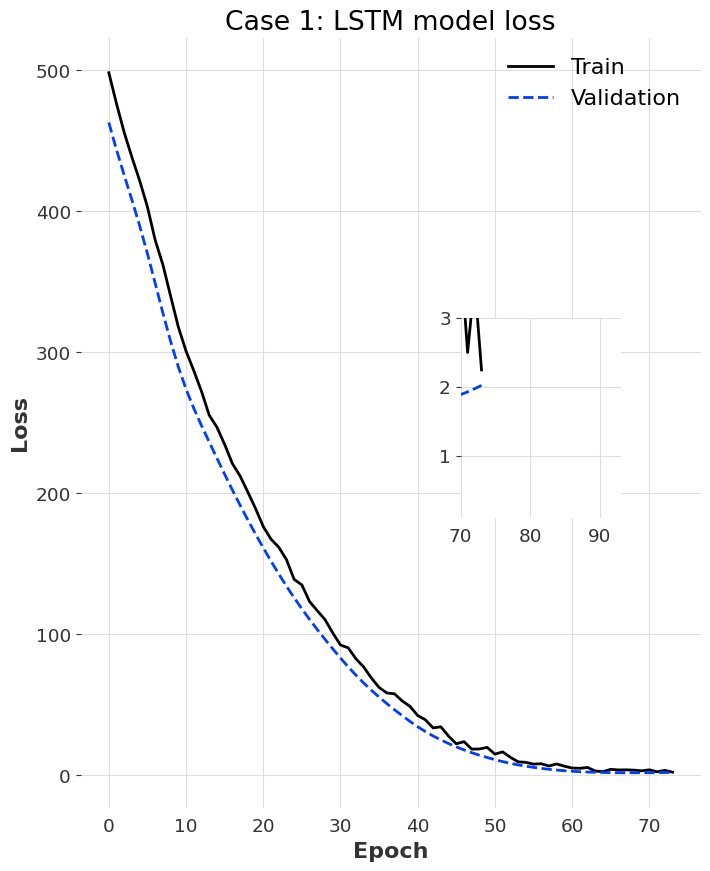

In [ ]:
plt.figure(figsize=(8, 10))
plt.plot(history.history['loss'], '-', linewidth=2)
plt.plot(history.history['val_loss'], '--', linewidth=2)
plt.grid(True)
plt.legend(['Train', 'Validation'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Case 1: LSTM model loss')
ax = plt.axes([0.6, 0.4, .20, .20])
plt.plot(history.history['loss'], '-', linewidth=2)
plt.plot(history.history['val_loss'], '--', linewidth=2)
plt.grid(True)
ax.set_ylim(0.1, 3)
ax.set_xlim(70, 93)

In [ ]:
trainPredict = model.predict(input_train_total_regular_cycle)
testPredict = model.predict(input_test_total_regular_cycle)
testPredict = np.round(testPredict)
testPredict

1/1 [==============================] - 0s 39ms/step


array([[31.,  6.],
       [31.,  6.],
       [31.,  6.],
       [31.,  6.],
       [31.,  6.]], dtype=float32)

In [ ]:
testScore = np.sqrt(mean_squared_error(output_test_total_regular_cycle, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

# calculate mean absolute error
testScore = mean_absolute_error(output_test_total_regular_cycle, testPredict)
print('Test Score: %.2f MAE' % (testScore))

# calculate r2 score
testScore = r2_score(output_test_total_regular_cycle, testPredict)
print('Test Score: %.2f R2' % (testScore))


Test Score: 2.55 RMSE
Test Score: 2.10 MAE
Test Score: -2.18 R2


In [ ]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('case1_history_lstm.csv', index=False)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
import warnings
warnings.filterwarnings("ignore")


In [ ]:
regular_cycle_data = pd.read_csv('irregular_cycle_data.csv')
features_regular_cycle_data, labels_regular_cycle_data = generate_final_features(regular_cycle_data)
input_train_regular_cycle, input_test_regular_cycle, output_train_regular_cycle, output_test_regular_cycle = split_dataset(features_regular_cycle_data, labels_regular_cycle_data, reshape=False)


In [ ]:
n_features = input_train_regular_cycle.shape[2]
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(input_train_regular_cycle.shape[1], input_train_regular_cycle.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32))
model.add(Dropout(0.2))
model.add(Dense(units=n_features, activation='relu'))

In [ ]:
opt=tf.keras.optimizers.Adam()
model.compile(loss='mean_squared_error', optimizer=opt)
    # add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(input_train_regular_cycle, output_train_regular_cycle, epochs=2000, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/2000
1/1 [==============================] - 10s 10s/step - loss: 786.5751 - val_loss: 600.7527
Epoch 2/2000
1/1 [==============================] - 0s 57ms/step - loss: 783.3459 - val_loss: 597.1185
Epoch 3/2000
1/1 [==============================] - 0s 57ms/step - loss: 778.9431 - val_loss: 593.4238
Epoch 4/2000
1/1 [==============================] - 0s 58ms/step - loss: 775.7121 - val_loss: 589.6378
Epoch 5/2000
1/1 [==============================] - 0s 54ms/step - loss: 769.5002 - val_loss: 585.7219
Epoch 6/2000
1/1 [==============================] - 0s 69ms/step - loss: 765.8647 - val_loss: 581.6309
Epoch 7/2000
1/1 [==============================] - 0s 56ms/step - loss: 759.6027 - val_loss: 577.3113
Epoch 8/2000
1/1 [==============================] - 0s 60ms/step - loss: 754.2812 - val_loss: 572.7269
Epoch 9/2000
1/1 [==============================] - 0s 57ms/step - loss: 751.9270 - val_loss: 567.8466
Epoch 10/2000
1/1 [==============================] - 0s 56ms/step - loss:

Text(0.5, 1.0, 'Case 2: LSTM model loss')

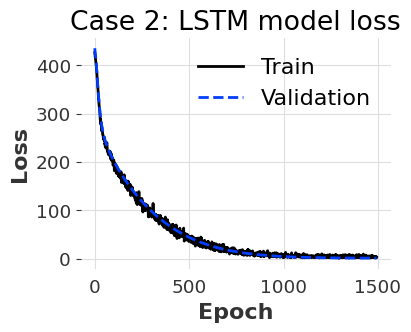

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(history.history['loss'], '-', linewidth=2)
plt.plot(history.history['val_loss'], '--', linewidth=2)
plt.grid(True)
plt.legend(['Train', 'Validation'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Case 2: LSTM model loss')

In [ ]:
testScore = np.sqrt(mean_squared_error(output_test_total_regular_cycle, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

# calculate mean absolute error
testScore = mean_absolute_error(output_test_total_regular_cycle, testPredict)
print('Test Score: %.2f MAE' % (testScore))

# calculate r2 score
testScore = r2_score(output_test_total_regular_cycle, testPredict)
print('Test Score: %.2f R2' % (testScore))


Test Score: 2.55 RMSE
Test Score: 2.10 MAE
Test Score: -2.18 R2


(1500.0, 1650.0)

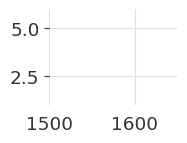

In [ ]:
ax = plt.axes([0.6, 0.4, .20, .20])
plt.plot(history.history['loss'], '-', linewidth=2)
plt.plot(history.history['val_loss'], '--', linewidth=2)
plt.grid(True)
ax.set_ylim(1, 6)
ax.set_xlim(1500, 1650)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
df =  pd.read_csv('synthetic_data.csv', sep=',', header=0)

In [ ]:
periods_data = calculate_datatime(df)
features, labels = generate_final_features(df)

In [ ]:
x_train, x_test, y_train, y_test  = train_test_split(features, labels, test_size=0.2, random_state=10)
# Redefinindo os dados para o modelo de regressão linear/machine learning
train_y=np.array(y_train)
train_x= np.array(x_train)
test_x= np.array(x_test)
test_y= np.array(y_test)
train_x = train_x.reshape((train_x.shape[0],train_x.shape[1]*train_x.shape[2]))
train_y = train_y.reshape((train_y.shape[0],train_y.shape[1]*1))
test_x = test_x.reshape((test_x.shape[0],test_x.shape[1]*test_x.shape[2]))
test_y = test_y.reshape((test_y.shape[0],test_y.shape[1]*1))


In [ ]:
model_RD=RandomForestRegressor(criterion='squared_error', random_state=30, n_estimators=50)
model_RD.fit(train_x, train_y)

RandomForestRegressor(n_estimators=50, random_state=30)

In [ ]:
y_pred=model_RD.predict(test_x)
output_pred = [[int(round(i[0])), int(round(i[1]))] for i in y_pred]

In [ ]:
cycle_length=[]
periods=[]
for i in range(len(output_pred)):
  cycle_length.append(output_pred[i][0] )
  periods.append(output_pred[i][1] )

In [ ]:
prediction_one_step = model_RD.predict([test_x[-1]])
cycles_numbers = np.arange(1, len(cycle_length)+1)

In [ ]:
plt.figure(figsize=(4,4))
plt.rcParams.update({'font.size': 16})

<Figure size 400x400 with 0 Axes>

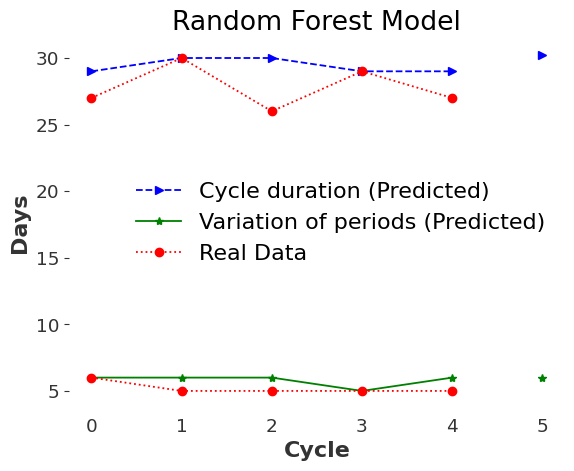

In [ ]:
plt.plot(cycle_length, '-->', color='blue')
plt.plot(periods, '-*', color='green')
plt.plot(test_y, ':o', color='red')
plt.plot(cycles_numbers[-1], predicao_um_passo_a_frente[0][0], '-->', color='blue')
plt.plot(cycles_numbers[-1], predicao_um_passo_a_frente[0][1], '-*', color='green')
plt.legend(['Cycle duration (Predicted)', 'Variation of periods (Predicted)', 'Real Data'])
plt.grid()
plt.xlabel('Cycle')
plt.ylabel('Days')
plt.title('Random Forest Model')
fig = plt.gcf()
plt.show()

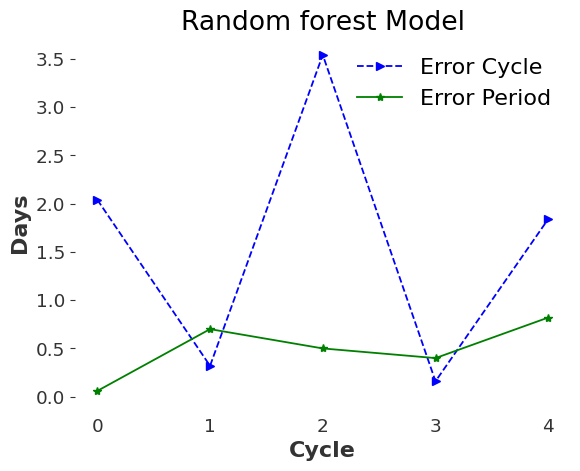

In [ ]:
error = abs(test_y-y_pred)
plt.plot(error[:,0], '-->', color='blue')
plt.plot(error[:,1], '-*', color='green')
plt.legend(['Error Cycle', 'Error Period'])
plt.grid()
plt.xlabel('Cycle')
plt.ylabel('Days')
plt.title('Random forest Model')
fig = plt.gcf()
plt.show()

In [ ]:
rms = sqrt(mean_squared_error(test_y, y_pred))
print('RMSE: ', rms)

    # calcular o MAE (Mean Absolute Error)
mae = np.mean(np.abs((test_y - y_pred)))
print('MAE: ', mae)

RMSE:  1.4758997255911388
MAE:  1.0379999999999998
